In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import time
import os, glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from src.utils import *
from src.loss import *
from src.model import *
from src.dataset import *

In [2]:
"""kitti_ds = KittiStereoLidar(
    im_left_dir=glob.glob("data/left_imgs/2011_09_26_drive_0001_sync/*"), 
    im_right_dir=glob.glob("data/right_imgs/2011_09_26_drive_0001_sync/*"),
    gt_left_dir=glob.glob("data/left_gt/2011_09_26_drive_0001_sync/*"), 
    gt_right_dir=glob.glob("data/right_gt/2011_09_26_drive_0001_sync/*"),
    transform=transforms.Compose([transforms.Resize((192,640)),
                                  transforms.ToTensor()])
)"""
kitti_ds = KittiStereoLidar(
    im_left_dir=glob.glob("data/left_imgs/*/*"), 
    im_right_dir=glob.glob("data/right_imgs/*/*"),
    gt_left_dir=glob.glob("data/left_gt/*/*"), 
    gt_right_dir=glob.glob("data/right_gt/*/*"),
    transform=transforms.Compose([transforms.Resize((192,640)),
                                  transforms.ToTensor()])
)
# 2011_09_26_drive_0001_sync/
# Resize issues
# Original(375,1242)
# (384, 1280)->(160,320)
# (192,640)->(96,320)

In [3]:
print(len(kitti_ds))
batch_size = 2
train_loader = DataLoader(dataset=kitti_ds, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=6)
 
dataiter = iter(train_loader) #21972
len(train_loader)

21972


10986

In [4]:
# Depth prediction networks for left & right view sets respectively
L = Network()
L = torch.nn.DataParallel(L).cuda()
R = Network()
R = torch.nn.DataParallel(R).cuda()

In [5]:
#Precalculate mapping parameters
sc = 320/1242
reconstruct_functions = [Reconstruction(date='2011_09_26',scaling=sc), 
                         Reconstruction(date='2011_09_28',scaling=sc),
                         Reconstruction(date='2011_09_29',scaling=sc), 
                         Reconstruction(date='2011_09_30',scaling=sc),
                         Reconstruction(date='2011_10_03',scaling=sc)]

consistency_functions = [Consistency(date='2011_09_26',scaling=sc), 
                         Consistency(date='2011_09_28',scaling=sc),
                         Consistency(date='2011_09_29',scaling=sc), 
                         Consistency(date='2011_09_30',scaling=sc),
                         Consistency(date='2011_10_03',scaling=sc)]

def normalize_prediction(map_input, scale=100):
    M, m=np.amax(map_input), np.amin(map_input)
    return (map_input - m)*(scale / (M-m))

def get_recon_loss(depth_maps, src_imgs, tar_imgs, direction, dates):
    
    batch_loss = 0
    for[dep, src, tar, dat] in zip(depth_maps, src_imgs, tar_imgs, dates):
        if dat=='2011_09_26':
            recf = reconstruct_functions[0]
        elif dat=='2011_09_28':
            recf = reconstruct_functions[1]
        elif dat=='2011_09_29':
            recf = reconstruct_functions[2]
        elif dat=='2011_09_30':
            recf = reconstruct_functions[3]
        elif dat=='2011_10_03':
            recf = reconstruct_functions[4]

        # Calculate sample loss
        sample_loss, _ = recf.compute_loss(dep, src, tar, direction, weighting=True)
        batch_loss += sample_loss

    return batch_loss / batch_size

def get_con_loss(depth_maps, tar_imgs, direction, dates):
    
    batch_loss = 0
    for[dep, tar, dat] in zip(depth_maps, tar_imgs, dates):
        if dat=='2011_09_26':
            recf = consistency_functions[0]
        elif dat=='2011_09_28':
            recf = consistency_functions[1]
        elif dat=='2011_09_29':
            recf = consistency_functions[2]
        elif dat=='2011_09_30':
            recf = consistency_functions[3]
        elif dat=='2011_10_03':
            recf = consistency_functions[4]

        # Calculate sample loss
        sample_loss, _ = recf.compute_loss(dep, tar, direction, weighting=False)
        batch_loss += sample_loss

    return batch_loss / batch_size

def get_su_loss(depth_maps, scan_files):
    
    batch_loss = 0
    for[dep, scan_file] in zip(depth_maps, scan_files):
        dots = np.load(scan_file) 

        sample_loss = gt_loss(dep, dots)
        batch_loss += sample_loss

    return batch_loss / batch_size

In [6]:
n_epochs = 1
alpha = 1
beta = 0.01
gamma = 0.01

lr = 1e-3
L_optimizer = torch.optim.Adam(L.parameters(), lr=lr)
R_optimizer = torch.optim.Adam(R.parameters(), lr=lr)
#uniform
#exp-1 & beta=0.05 breaks around 2%

Epoch: 1 (0.05%)	Step Loss: 0.049368 
	Su: 0.099952 	Unsu: 0.038594 	Con: 0.037384 
	max/min:(tensor(0.4971, device='cuda:0'), tensor(1.00000e-02 *
       2.2387, device='cuda:0'))


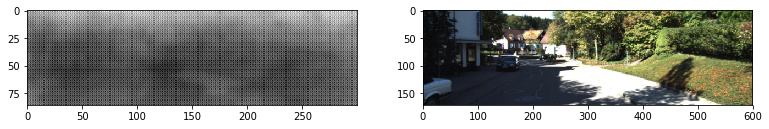

Epoch: 1 (0.09%)	Step Loss: 0.047293 
	Su: 0.095300 	Unsu: 0.046194 	Con: 0.071688 
	max/min:(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))


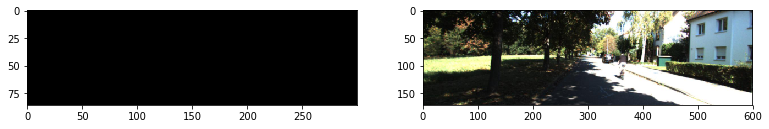

Epoch: 1 (0.14%)	Step Loss: 0.042925 
	Su: 0.086433 	Unsu: 0.051884 	Con: 0.061644 
	max/min:(tensor(0.3253, device='cuda:0'), tensor(1.00000e-03 *
       4.5963, device='cuda:0'))


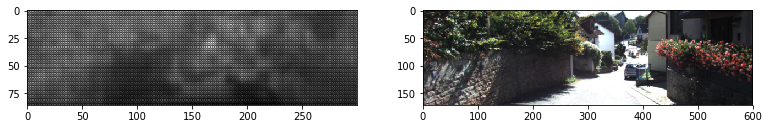

Epoch: 1 (0.18%)	Step Loss: 0.036715 
	Su: 0.073624 	Unsu: 0.064712 	Con: 0.062748 
	max/min:(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))


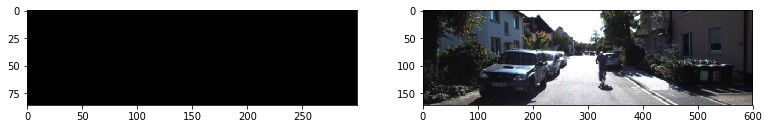

Epoch: 1 (0.23%)	Step Loss: 0.032985 
	Su: 0.065945 	Unsu: 0.070744 	Con: 0.063632 
	max/min:(tensor(0.2693, device='cuda:0'), tensor(1.00000e-03 *
       2.8764, device='cuda:0'))


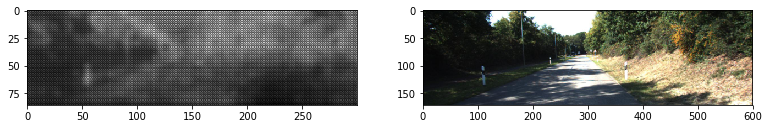

Epoch: 1 (0.27%)	Step Loss: 0.034055 
	Su: 0.067946 	Unsu: 0.073090 	Con: 0.079486 
	max/min:(tensor(0.2773, device='cuda:0'), tensor(1.00000e-03 *
       1.9112, device='cuda:0'))


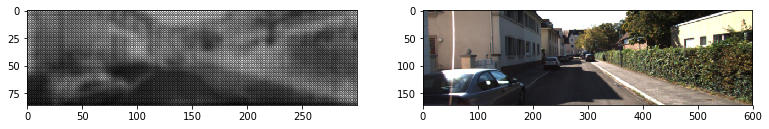

Epoch: 1 (0.32%)	Step Loss: 0.034013 
	Su: 0.067823 	Unsu: 0.075065 	Con: 0.081223 
	max/min:(tensor(0.2750, device='cuda:0'), tensor(1.00000e-03 *
       1.9340, device='cuda:0'))


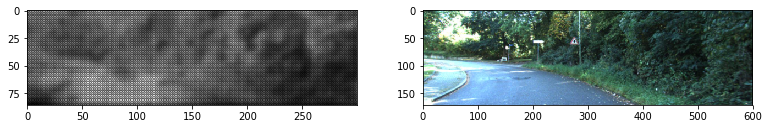

Epoch: 1 (0.36%)	Step Loss: 0.034009 
	Su: 0.067785 	Unsu: 0.076857 	Con: 0.082563 
	max/min:(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))


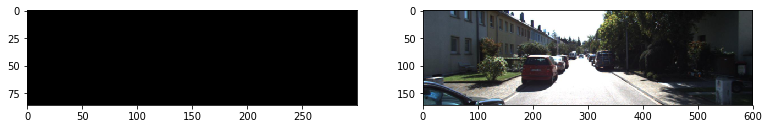

Epoch: 1 (0.41%)	Step Loss: 0.035250 
	Su: 0.070192 	Unsu: 0.078057 	Con: 0.093697 
	max/min:(tensor(0.2876, device='cuda:0'), tensor(1.00000e-04 *
       5.9914, device='cuda:0'))


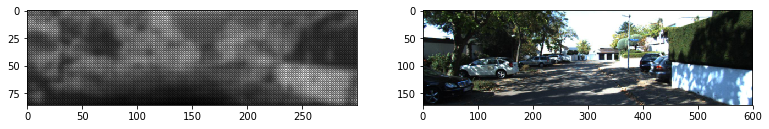

Epoch: 1 (0.46%)	Step Loss: 0.034056 
	Su: 0.067784 	Unsu: 0.079983 	Con: 0.088969 
	max/min:(tensor(0.2669, device='cuda:0'), tensor(1.00000e-04 *
       6.9241, device='cuda:0'))


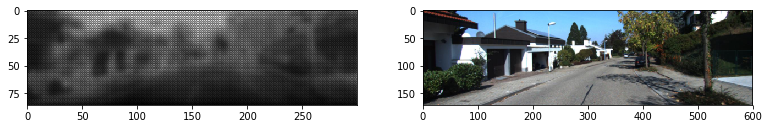

Epoch: 1 (0.50%)	Step Loss: 0.032563 
	Su: 0.064742 	Unsu: 0.081627 	Con: 0.087066 
	max/min:(tensor(0.2791, device='cuda:0'), tensor(1.00000e-04 *
       2.3569, device='cuda:0'))


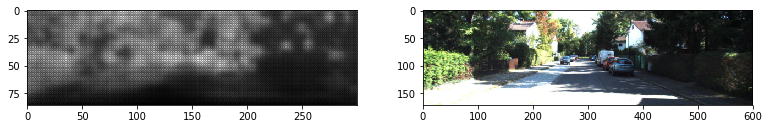

Epoch: 1 (0.55%)	Step Loss: 0.031756 
	Su: 0.063113 	Unsu: 0.083448 	Con: 0.083570 
	max/min:(tensor(0.2678, device='cuda:0'), tensor(1.00000e-04 *
       3.3103, device='cuda:0'))


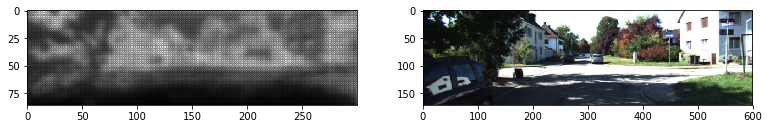

Epoch: 1 (0.59%)	Step Loss: 0.031104 
	Su: 0.061784 	Unsu: 0.082788 	Con: 0.084032 
	max/min:(tensor(0.3042, device='cuda:0'), tensor(1.00000e-05 *
       7.2980, device='cuda:0'))


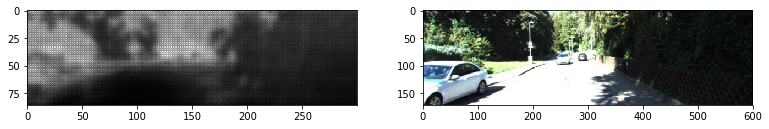

Epoch: 1 (0.64%)	Step Loss: 0.030546 
	Su: 0.060631 	Unsu: 0.084058 	Con: 0.084306 
	max/min:(tensor(0.2900, device='cuda:0'), tensor(1.00000e-04 *
       3.3256, device='cuda:0'))


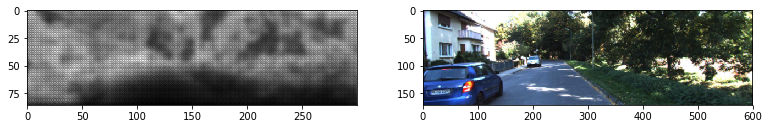

Epoch: 1 (0.68%)	Step Loss: 0.030387 
	Su: 0.060325 	Unsu: 0.083482 	Con: 0.083106 
	max/min:(tensor(0.3237, device='cuda:0'), tensor(1.00000e-04 *
       2.2025, device='cuda:0'))


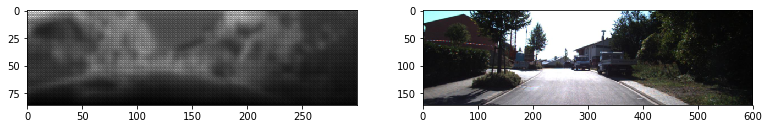

Epoch: 1 (0.73%)	Step Loss: 0.030608 
	Su: 0.060744 	Unsu: 0.083557 	Con: 0.086072 
	max/min:(tensor(0.3226, device='cuda:0'), tensor(1.00000e-04 *
       2.6962, device='cuda:0'))


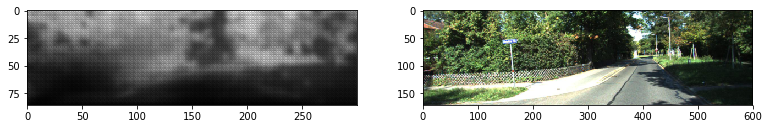

Epoch: 1 (0.77%)	Step Loss: 0.031093 
	Su: 0.061741 	Unsu: 0.084059 	Con: 0.084756 
	max/min:(tensor(0.3248, device='cuda:0'), tensor(1.00000e-05 *
       6.2677, device='cuda:0'))


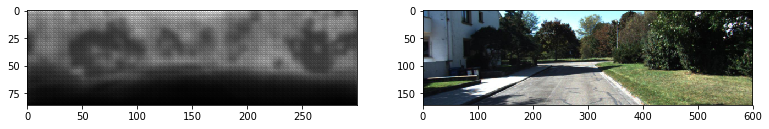

Epoch: 1 (0.82%)	Step Loss: 0.030336 
	Su: 0.060204 	Unsu: 0.084458 	Con: 0.083739 
	max/min:(tensor(0.3096, device='cuda:0'), tensor(1.00000e-04 *
       1.1834, device='cuda:0'))


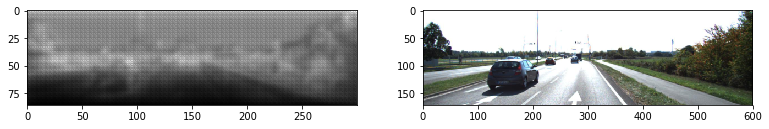

Epoch: 1 (0.86%)	Step Loss: 0.030517 
	Su: 0.060557 	Unsu: 0.083791 	Con: 0.086010 
	max/min:(tensor(0.3177, device='cuda:0'), tensor(1.00000e-04 *
       1.2110, device='cuda:0'))


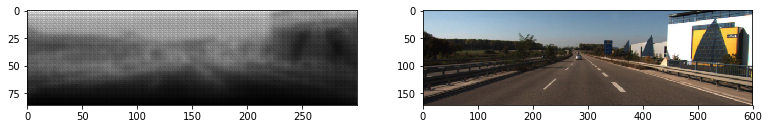

Epoch: 1 (0.91%)	Step Loss: 0.029588 
	Su: 0.058689 	Unsu: 0.083155 	Con: 0.083851 
	max/min:(tensor(0.3002, device='cuda:0'), tensor(1.00000e-04 *
       2.5701, device='cuda:0'))


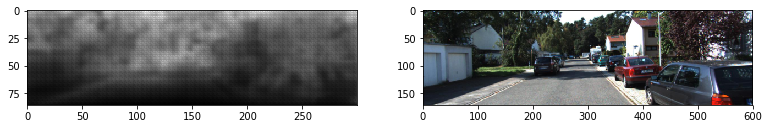

Epoch: 1 (0.96%)	Step Loss: 0.030044 
	Su: 0.059619 	Unsu: 0.082166 	Con: 0.084935 
	max/min:(tensor(0.3172, device='cuda:0'), tensor(1.00000e-05 *
       9.2311, device='cuda:0'))


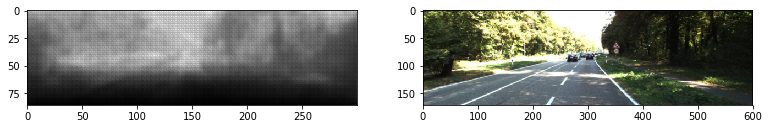

Epoch: 1 (1.00%)	Step Loss: 0.030198 
	Su: 0.059924 	Unsu: 0.081390 	Con: 0.086690 
	max/min:(tensor(0.3256, device='cuda:0'), tensor(1.00000e-04 *
       1.6205, device='cuda:0'))


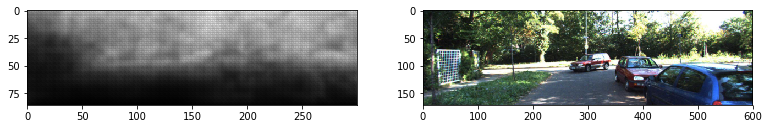

Epoch: 1 (1.05%)	Step Loss: 0.029646 
	Su: 0.058809 	Unsu: 0.081210 	Con: 0.085661 
	max/min:(tensor(0.3711, device='cuda:0'), tensor(1.00000e-05 *
       9.2040, device='cuda:0'))


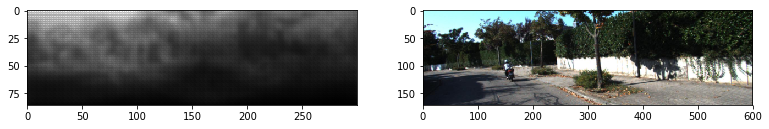

Epoch: 1 (1.09%)	Step Loss: 0.029363 
	Su: 0.058235 	Unsu: 0.080880 	Con: 0.085595 
	max/min:(tensor(0.3156, device='cuda:0'), tensor(1.00000e-04 *
       8.5470, device='cuda:0'))


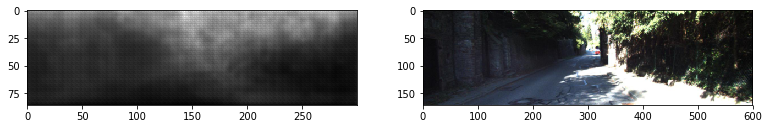

Epoch: 1 (1.14%)	Step Loss: 0.028891 
	Su: 0.057284 	Unsu: 0.080555 	Con: 0.084728 
	max/min:(tensor(0.3716, device='cuda:0'), tensor(1.00000e-04 *
       1.6718, device='cuda:0'))


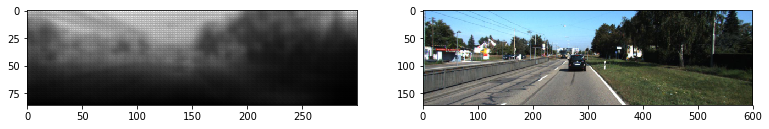

Epoch: 1 (1.18%)	Step Loss: 0.029090 
	Su: 0.057687 	Unsu: 0.079470 	Con: 0.086183 
	max/min:(tensor(0.3763, device='cuda:0'), tensor(1.00000e-04 *
       1.8887, device='cuda:0'))


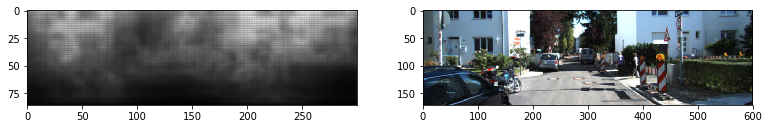

Epoch: 1 (1.23%)	Step Loss: 0.029251 
	Su: 0.058022 	Unsu: 0.078871 	Con: 0.086067 
	max/min:(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))


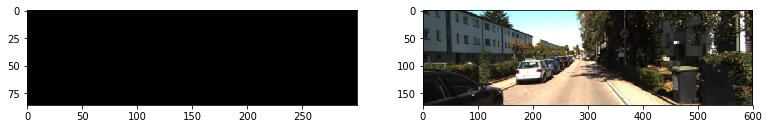

Epoch: 1 (1.27%)	Step Loss: 0.028816 
	Su: 0.057165 	Unsu: 0.078161 	Con: 0.083753 
	max/min:(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))


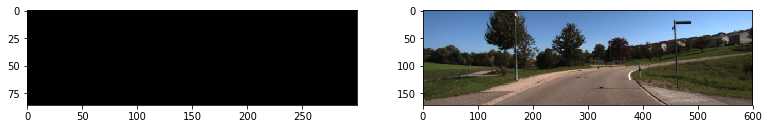

Epoch: 1 (1.32%)	Step Loss: 0.028426 
	Su: 0.056380 	Unsu: 0.077957 	Con: 0.083047 
	max/min:(tensor(0.3695, device='cuda:0'), tensor(1.00000e-05 *
       2.7415, device='cuda:0'))


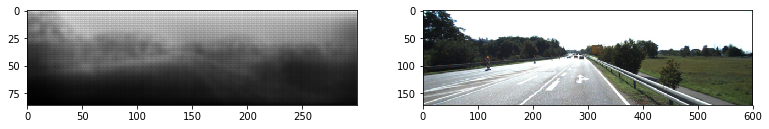

Epoch: 1 (1.37%)	Step Loss: 0.028791 
	Su: 0.057139 	Unsu: 0.077142 	Con: 0.082303 
	max/min:(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))


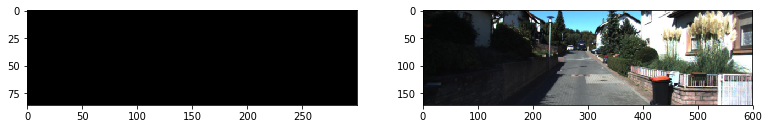

Epoch: 1 (1.41%)	Step Loss: 0.028433 
	Su: 0.056420 	Unsu: 0.076693 	Con: 0.081683 
	max/min:(tensor(0.3930, device='cuda:0'), tensor(1.00000e-04 *
       2.4435, device='cuda:0'))


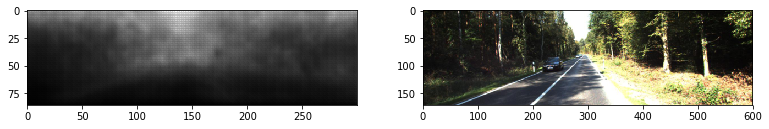

Epoch: 1 (1.46%)	Step Loss: 0.028767 
	Su: 0.057111 	Unsu: 0.076344 	Con: 0.081044 
	max/min:(tensor(0.4094, device='cuda:0'), tensor(1.00000e-04 *
       2.7608, device='cuda:0'))


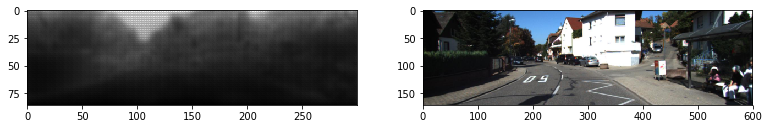

Epoch: 1 (1.50%)	Step Loss: 0.028589 
	Su: 0.056766 	Unsu: 0.075747 	Con: 0.079865 
	max/min:(tensor(0.4011, device='cuda:0'), tensor(1.00000e-05 *
       5.7049, device='cuda:0'))


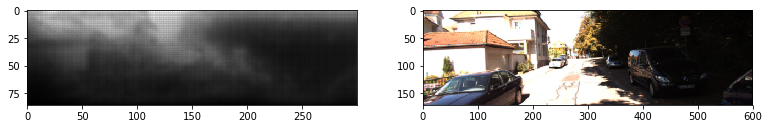

Epoch: 1 (1.55%)	Step Loss: 0.029166 
	Su: 0.057959 	Unsu: 0.074810 	Con: 0.079211 
	max/min:(tensor(0.4381, device='cuda:0'), tensor(1.00000e-05 *
       9.7591, device='cuda:0'))


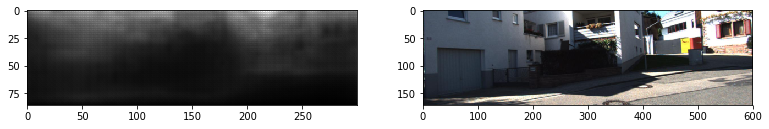

Epoch: 1 (1.59%)	Step Loss: 0.029301 
	Su: 0.058237 	Unsu: 0.074307 	Con: 0.079365 
	max/min:(tensor(0.3999, device='cuda:0'), tensor(1.00000e-03 *
       1.0119, device='cuda:0'))


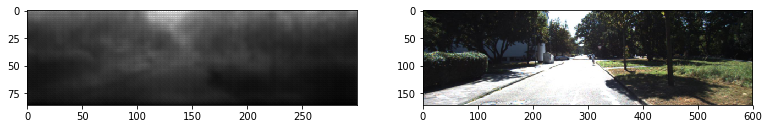

Epoch: 1 (1.64%)	Step Loss: 0.029119 
	Su: 0.057870 	Unsu: 0.073822 	Con: 0.079436 
	max/min:(tensor(0.3935, device='cuda:0'), tensor(1.00000e-03 *
       1.0755, device='cuda:0'))


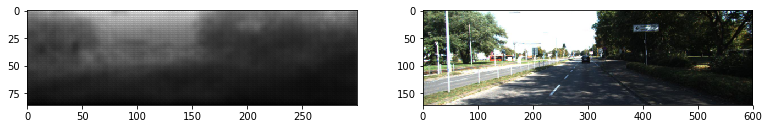

Epoch: 1 (1.68%)	Step Loss: 0.029381 
	Su: 0.058414 	Unsu: 0.073319 	Con: 0.078953 
	max/min:(tensor(0.4297, device='cuda:0'), tensor(1.00000e-03 *
       1.2785, device='cuda:0'))


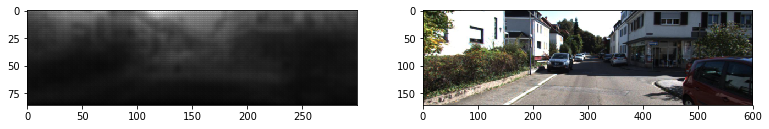

Epoch: 1 (1.73%)	Step Loss: 0.029488 
	Su: 0.058637 	Unsu: 0.072841 	Con: 0.079023 
	max/min:(tensor(0.4078, device='cuda:0'), tensor(1.00000e-04 *
       6.4710, device='cuda:0'))


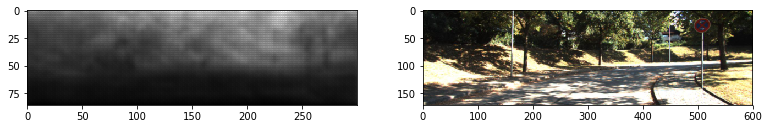

Epoch: 1 (1.77%)	Step Loss: 0.029320 
	Su: 0.058297 	Unsu: 0.072475 	Con: 0.079074 
	max/min:(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))


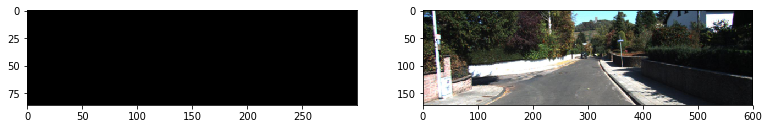

Epoch: 1 (1.82%)	Step Loss: 0.029298 
	Su: 0.058259 	Unsu: 0.072129 	Con: 0.078697 
	max/min:(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))


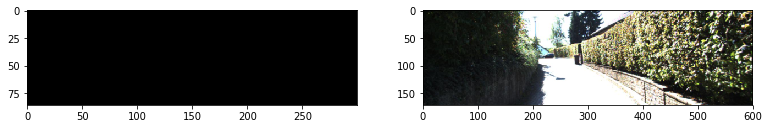

Epoch: 1 (1.87%)	Step Loss: 0.029653 
	Su: 0.058989 	Unsu: 0.071582 	Con: 0.078814 
	max/min:(tensor(0.4069, device='cuda:0'), tensor(1.00000e-03 *
       1.5461, device='cuda:0'))


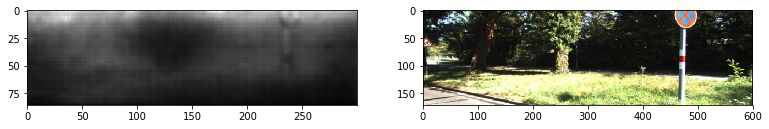

Epoch: 1 (1.91%)	Step Loss: 0.029741 
	Su: 0.059172 	Unsu: 0.071213 	Con: 0.078857 
	max/min:(tensor(0.5000, device='cuda:0'), tensor(0.5000, device='cuda:0'))


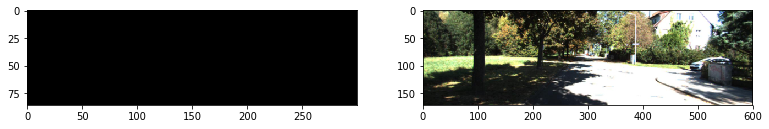

Epoch: 1 (1.96%)	Step Loss: 0.029704 
	Su: 0.059101 	Unsu: 0.071088 	Con: 0.078475 
	max/min:(tensor(0.4438, device='cuda:0'), tensor(1.00000e-04 *
       3.4886, device='cuda:0'))


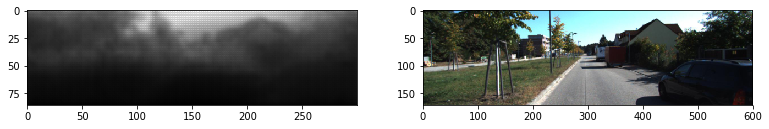

Epoch: 1 (2.00%)	Step Loss: 0.029794 
	Su: 0.059288 	Unsu: 0.070665 	Con: 0.078539 
	max/min:(tensor(0.4460, device='cuda:0'), tensor(1.00000e-04 *
       5.2998, device='cuda:0'))


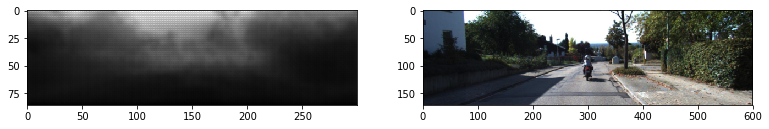

In [ ]:
L.train()
R.train()
img=None
for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    s_step, r_step, c_step = 0.0, 0.0, 0.0

    batch_count = 1
    print_every = 5 #20
    time_start = time.time()

    for images_l, images_r, scans_l, scans_r in train_loader:
        L_optimizer.zero_grad()
        R_optimizer.zero_grad()
        
        # Move to cuda
        images_l = images_l.cuda()
        images_r = images_r.cuda()
        
        # Forward pass, make predictions
        depths_l = L(images_l)
        depths_r = R(images_r)

        drive_dates = [s[13:23] for s in scans_l]
        
        # Compute supervised (lidar) losses
        s_loss_L = get_su_loss(depth_maps=depths_l, scan_files=scans_l)
        s_loss_R = get_su_loss(depth_maps=depths_r, scan_files=scans_r)
        
        # Compute reconstruction losses
        r_loss_L = get_recon_loss(depth_maps=depths_l, 
                                  src_imgs=images_l, 
                                  tar_imgs=images_r, 
                                  direction='L2R', dates=drive_dates)
        r_loss_R = get_recon_loss(depth_maps=depths_r, 
                                  src_imgs=images_l, 
                                  tar_imgs=images_l, 
                                  direction='R2L', dates=drive_dates)
        
        # Compute depth map L-R consistency losses
        c_loss_L = get_con_loss(depth_maps=depths_l,  
                                tar_imgs=depths_r, 
                                direction='L2R', dates=drive_dates)
        c_loss_R = get_con_loss(depth_maps=depths_r,  
                                tar_imgs=depths_l, 
                                direction='R2L', dates=drive_dates)
        
        # Weight & sum losses
        loss = (alpha*(s_loss_L + s_loss_R) \
              + beta *(r_loss_L + r_loss_R) \
              + gamma*(c_loss_L + c_loss_R)) / (2*(alpha+beta+gamma))

        # Back propagation & optimize
        loss.backward()
        L_optimizer.step()
        R_optimizer.step()

        train_loss += loss.item()
        s_step += (s_loss_L.item() + s_loss_R.item())
        r_step += (r_loss_L.item() + r_loss_R.item())
        c_step += (c_loss_L.item() + c_loss_R.item())
        
        step_loss = train_loss / (batch_count * batch_size)
        if batch_count % print_every == 0:
            print('Epoch: {} ({:.2f}%)\tStep Loss: {:.6f} \n\tSu: {:.6f} \tUnsu: {:.6f} \tCon: {:.6f} \n\tmax/min:{}'.format(
                epoch+1,
                100*(batch_count / len(train_loader)), 
                step_loss,
                s_step / (batch_count * batch_size),
                r_step / (batch_count * batch_size),
                c_step / (batch_count * batch_size),
                (depths_l[0].max(), depths_l[0].min())
            ))
            npd = np.transpose(depths_l[0].cpu().detach().numpy(), (1,2,0)).squeeze()
            npd = npd[5:-5, 10:-10]
            npd = (npd-np.amin(npd)) / (np.amax(npd) - np.amin(npd) + 1e-4) #normalize display, prevent div by 0
            npi = np.transpose(images_l[0].cpu().detach().numpy(), (1,2,0))
            npi = npi[10:-10, 20:-20]
            
            f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
            ax1.imshow(npd, cmap='gray')
            ax2.imshow(npi)
            plt.show()
        batch_count += 1

    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler) #image pair count
    time_elapsed = time.time() - time_start

    print('Epoch: {} \tTraining Loss: {:.6f} \tTime: {} s'.format(
        epoch+1, 
        train_loss,
        round(time_elapsed, 4)
        ))


In [ ]:
#r = np.transpose(img.cpu().detach().numpy(), (1,2,0))
#plt.imshow(r)
#plt.show()

In [ ]:
L.eval()
R.eval()
test_loader = DataLoader(dataset=kitti_ds, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=6)
 
dataiter = iter(train_loader) #21972

In [ ]:
images_l, images_r, scans_l, scans_r = dataiter.next()
depths_l = L(images_l)
npd = np.transpose(depths_l[0].cpu().detach().numpy(), (1,2,0)).squeeze()
npi = np.transpose(images_l[0].cpu().detach().numpy(), (1,2,0))
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.imshow(npd, cmap='gray')
ax2.imshow(npi)
plt.show()
np.amax(npd), np.amin(npd)